# Imports

In [1]:
import pandas as pd
import string
import numpy as np
import time

import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('whitegrid')
%matplotlib inline

import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC

# Read in and view data

In [2]:
reddit = pd.read_csv('../../datasets/reddit_train.csv') #read in the dataset
reddit.drop(['num', 'X'], axis = 1, inplace = True) # These columns provide no information for classification so we remove them
reddit['REMOVED'] = reddit['REMOVED'].map({1:'Yes', 0:'No'}) # To make the understanding of the dataset clearer for now

reddit.head() # see the first 5 rows of data

,BODY,REMOVED
0,Always be wary of news articles that cite unpu...,No
1,The problem I have with this is that the artic...,No
2,"This is indicative of a typical power law, and...",No
3,This doesn't make sense. Chess obviously trans...,No
4,1. I dispute that gene engineering is burdenso...,No


In [3]:
reddit.describe() # stats about the data

,BODY,REMOVED
count,21336,21336
unique,21332,2
top,Why is every comment removed?,No
freq,3,14479


In [4]:
reddit.groupby('REMOVED').describe() # stats about the data group by category

BODY                                                               
         count unique                                                top freq
REMOVED                                                                      
No       14479  14479  One very surprising effect of having a dog aga...    1
Yes       6857   6853                      Why is every comment removed?    3

# Exploratory analysis

In [5]:
reddit['LENGTH'] = reddit['BODY'].apply(len) # find the length of each comment

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000015D6810D5F8>,
      dtype=object)

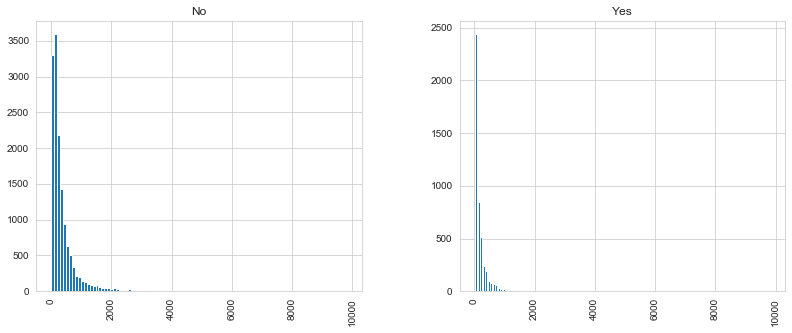

In [6]:
reddit.hist(column = 'LENGTH', bins = 100, by = 'REMOVED', sharex = True, figsize = (13,5)) # histogram of num of characters in each comment

From this plot we can see that the length of the comment does not seem to be a good indicator of whether a message was removed or not, this is as expected but it is always worth exploring the data.

In [7]:
def extract_punc(text):
    punc = [char for char in text if char in string.punctuation] # add punctuation to list
    return len(punc)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000015D4C83E978>,
      dtype=object)

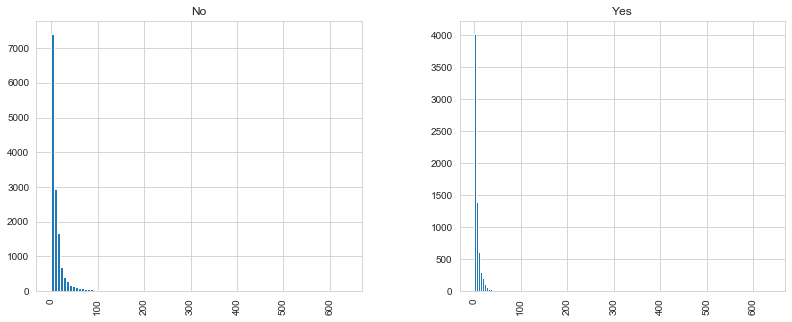

In [8]:
reddit['NUM_PUNC'] = reddit['BODY'].apply(extract_punc) # apply above function to each row of data
reddit.hist(column = 'NUM_PUNC', bins = 100, by = 'REMOVED', sharex = True, figsize = (13,5)) # histogram of num of punctuation marks

Again this shows that there is little to no difference between the distribution of number of punctuation points used in comments that were removed and not removed meaning it is not a good indicator to add to our classifier.

# Process data

It is important to preprocess your text data into a simpler form, for example removed words that carry no weight, e.g. 'I' or 'an' so as to not drown out the important words that do carry meaning, we will also remove punctuation from our comments, however this could be an important feature in some datasets.

In [9]:
def text_process(text):
    no_punc = [char for char in text if char not in string.punctuation] # non punctuation characters
    no_punc = ''.join(no_punc) # join back together to a single string
    return [word for word in no_punc.split() if word.lower() not in stopwords.words('english')] # remove stopwords

In [10]:
X_train, X_test, y_train, y_test = train_test_split(reddit['BODY'], reddit['REMOVED']) # split data into train and test set

In [11]:
text_pipeline = Pipeline([('bow', CountVectorizer(analyzer=text_process)), # create pipline
                            ('tfidf', TfidfTransformer()), # Term Frequency Inverse Document Frequency
                            ('NaiveBayes', MultinomialNB()) # NaiveBayes algorithm
                        ])

# Train, test  and adapt models
Note: These models may take a while to train, particularly on a slow computer or laptop

In [12]:
remove_analysis = text_pipeline.fit(X_train, y_train) # run the pipeline
pred = remove_analysis.predict(X_test) # predict values based on model

print(accuracy_score(y_test, pred), '\n\n')
print(classification_report(y_test, pred), '\n\n')
print(confusion_matrix(y_test, pred), '\n\n')


0.6934758155230596 


              precision    recall  f1-score   support

          No       0.69      1.00      0.82      3633
         Yes       0.85      0.05      0.09      1701

    accuracy                           0.69      5334
   macro avg       0.77      0.52      0.45      5334
weighted avg       0.74      0.69      0.58      5334
 


[[3619   14]
 [1621   80]] 




We can see that although the accuracy score of this model seemed decent at around 68%, the actual model is terrible, this could be due to the significant class imbalance. Following, we create a model where the classes are evenly balanced

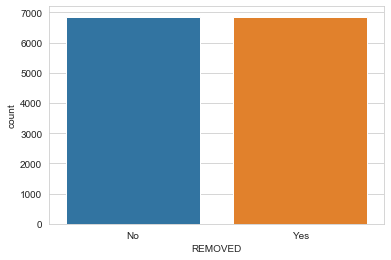

In [13]:
reddit_no = reddit[reddit['REMOVED'] == 'No'] # data from the No class
reddit_yes = reddit[reddit['REMOVED'] == 'Yes'] # data from the Yes class
to_select = min(len(reddit_no), len(reddit_yes)) # length of smallest dataset

reddit = pd.concat([reddit_no.iloc[:to_select,:], reddit_yes.iloc[:to_select,:]]) # combine the datasets so they are balanced


sns.countplot(reddit['REMOVED'])

In [14]:
X_train, X_test, y_train, y_test = train_test_split(reddit['BODY'], reddit['REMOVED']) # split training data into train and test

In [15]:
remove_analysis_balanced = text_pipeline.fit(X_train, y_train) # fit pipeline
pred_balanced = remove_analysis_balanced.predict(X_test) # predict values

print(accuracy_score(y_test, pred_balanced), '\n\n')
print(classification_report(y_test, pred_balanced), '\n\n')
print(confusion_matrix(y_test, pred_balanced), '\n\n')

0.689997083697871 


              precision    recall  f1-score   support

          No       0.67      0.75      0.71      1737
         Yes       0.71      0.63      0.67      1692

    accuracy                           0.69      3429
   macro avg       0.69      0.69      0.69      3429
weighted avg       0.69      0.69      0.69      3429
 


[[1305  432]
 [ 631 1061]] 




print('Although the accuracy of the model is approximitely equal to that of the previous one, the overall performance metrics are much better as the model predicts more evenly about the classes. This is demonstrative as to why you need to explore your data before blindly fitting a model to it and looking at only the accuracy score as this can paint a very false picture of how good your model is. The phrase 'Garbage in garbage out comes to mind here'.

To make the predictions better, another thing that might work is stemming. This is the process of attempting to reduce a word down to it's base word, e.g. running would become run. Lets try this and see if it has an impact on our predictions.(we will use the same balanced dataset as the previous model)

In [16]:
def text_process_with_stem(text):
    ps = PorterStemmer() # stemmer object
    no_punc = [char for char in text if char not in string.punctuation] # remove punctuation
    no_punc = ''.join(no_punc) # combine to a string
    no_stops = [word for word in no_punc.split() if word.lower() not in stopwords.words('english')] # remove stopwords
    words_ps = [ps.stem(word.lower()) for word in no_stops] # stem words
    return words_ps

In [17]:
text_pipeline_stem = Pipeline([('bow', CountVectorizer(analyzer=text_process_with_stem)), # changed analyzer
                            ('tfidf', TfidfTransformer()),
                            ('NaiveBayes', MultinomialNB())
                        ])

In [18]:
X_train, X_test, y_train, y_test = train_test_split(reddit['BODY'], reddit['REMOVED']) # split training data

In [19]:
remove_analysis_balanced_stem = text_pipeline_stem.fit(X_train, y_train) # fit model
pred_balanced_stem = remove_analysis_balanced_stem.predict(X_test) # predict off of model

print(accuracy_score(y_test, pred_balanced_stem), '\n\n')
print(classification_report(y_test, pred_balanced_stem), '\n\n')
print(confusion_matrix(y_test, pred_balanced_stem), '\n\n')

0.6999125109361329 


              precision    recall  f1-score   support

          No       0.68      0.75      0.71      1723
         Yes       0.72      0.65      0.68      1706

    accuracy                           0.70      3429
   macro avg       0.70      0.70      0.70      3429
weighted avg       0.70      0.70      0.70      3429
 


[[1285  438]
 [ 591 1115]] 




This model performs very simmilar to the previous model, it is possibly marginally better but this will likely depend on how the data is split. Instead of stemming, we could try Lemmatizing the words.

In [20]:
def text_process_with_lemma(text):
    lemma = WordNetLemmatizer()
    no_punc = [char for char in text if char not in string.punctuation]
    no_punc = ''.join(no_punc)
    no_stops = [word for word in no_punc.split() if word.lower() not in stopwords.words('english')]
    words_lemma = [lemma.lemmatize(word.lower()) for word in no_stops] # Lemmatize words
    return words_lemma

In [21]:
text_pipeline_lemma = Pipeline([('bow', CountVectorizer(analyzer=text_process_with_lemma)), # changed analyzer
                            ('tfidf', TfidfTransformer()),
                            ('NaiveBayes', MultinomialNB())
                        ])

In [22]:
X_train, X_test, y_train, y_test = train_test_split(reddit['BODY'], reddit['REMOVED']) # split data

In [23]:
remove_analysis_balanced_lemma = text_pipeline_lemma.fit(X_train, y_train) # fit model
pred_balanced_lemma = remove_analysis_balanced_lemma.predict(X_test) # predict unseen instances

print(accuracy_score(y_test, pred_balanced_stem), '\n\n')
print(classification_report(y_test, pred_balanced_stem), '\n\n')
print(confusion_matrix(y_test, pred_balanced_stem), '\n\n')

0.49547973170020415 


              precision    recall  f1-score   support

          No       0.50      0.54      0.52      1722
         Yes       0.49      0.45      0.47      1707

    accuracy                           0.50      3429
   macro avg       0.50      0.50      0.49      3429
weighted avg       0.50      0.50      0.49      3429
 


[[934 788]
 [942 765]] 




This model appears to be no better than chance at predicting whether a comment should be removed, therefore we abandon this approach.

# Potential future improvements

There are still steps that could be taken to potentially improve the prediction performance of our models. For example, if we were to process our data further, we could expand contractions in each comment and then do further processing after these extra words have been introduced to get better results. The other option is to choose a different algorthim (for example a Support vector machine) and tune the hyper-parameters to our model or we could use a different method altogether, such as a deep neural network. All of these are potential options but will not be explored in this notebook. 